## Acceleration of a FIR filter on the PYNQ-Z2
This tutorial demonstrates how to accelerate a Python function on the Zynq-7000 using PYNQ. We begin by testing a software FIR impolemntation, the SciPy function `lfilter`, and measuring It's performance. Then we load a custom overlay with a hardware FIR, and compare It's performance to the software implementation.

### Plot function for use In this notebook
The first code block below defines a function that we will use for plotting data throughout this notebook. Note that the function has a `n_samples` argument so that we can limit the number of samples to plot. Plotting more than a few thousand samples can be very slow and consume a lot of RAM.

#### https://www.youtube.com/watch?v=LoLCtSzj9BU

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec,in_signal,n_samples,out_signal=None):
    plt.figure()
    plt.subplot(1,1,1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6, in_signal[:n_samples], 'y-',label='Input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6, out_signal[:n_samples], 'g-',linewidth=2, label='FIR output')
    plt.legend()

### Generate the Input signal
The next code block will generate a "noisy" signal that we will use as input to the FIR implementations. The main signal is a 200kHz sinusold but we have added lower amplitude sinusoids at 46MHz and 12MHz to simulate noise.

Number of samples:  200000


<IPython.core.display.Javascript object>


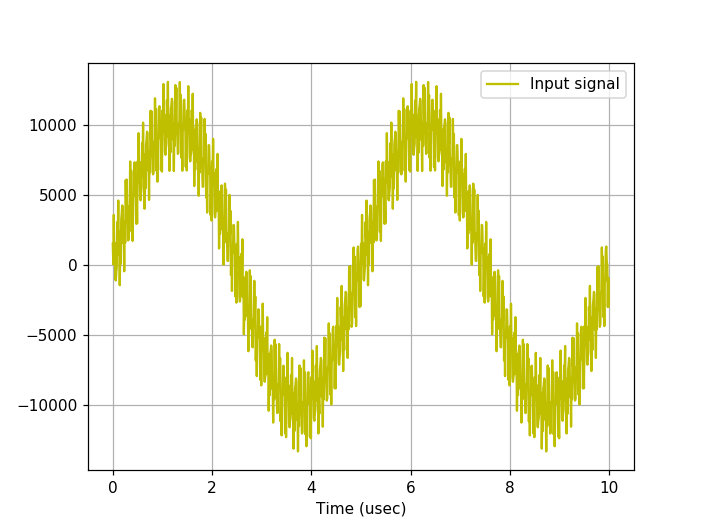

In [2]:
import numpy as np

# Total time
T = 0.002
# Sampling frequency
fs = 100e6
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)
# Samples of the signal
samples = 10000*np.sin(0.2e6*2*np.pi*t) + 1500*np.cos(46e6*2*np.pi*t) + 2000*np.sin(12e6*2*np.pi*t)
# Convert samples to 32-bit integers
samples = samples.astype(np.int32)
print('Number of samples: ', len(samples))

# Plot signal to the notebook
plot_to_notebook(t, samples, 1000)

### Software FIR filter using SciPy
Now we use the `lfilter` function from SciPy to filter the signal using our filter coefficients. The coefficients Implement a low pass filter with passband 0-5MHz, and they were generate using this website: http://t-filter.engineerjs.com/

Software FIR execution time:  0.08446717262268066


<IPython.core.display.Javascript object>


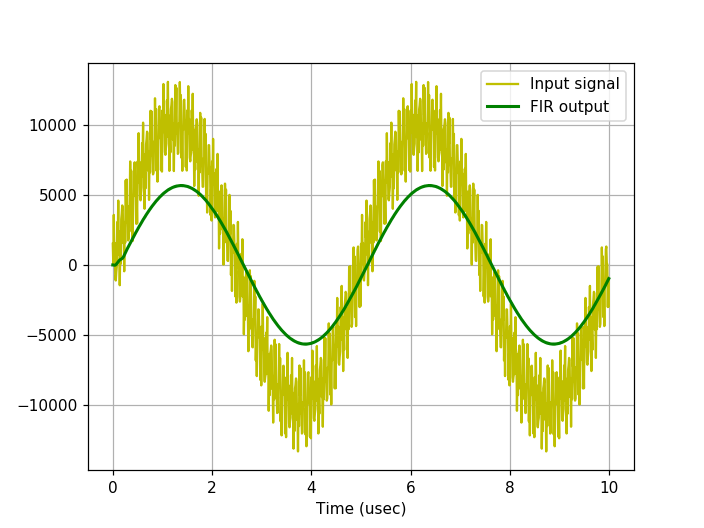

In [3]:
from scipy.signal import lfilter

coeffs = [-255,-260,-312,-288,-144,153,616,1233,1963,2739,3474,4081,4481,4620,4481,4081,3474,2739,1963,1233,616,153,-144,-288,-312,-260,-255]

import time
start_time = time.time()
sw_fir_output = lfilter(coeffs, 70e3, samples)
stop_time = time.time()
sw_exec_time = stop_time - start_time
print('Software FIR execution time: ', sw_exec_time)

# Plot the result to notebook
plot_to_notebook(t, samples,1000,out_signal=sw_fir_output)

### Hardware FIR implementation
In the following code blocks, we test out the hardware FIR implementation and measure it's perform

In [7]:
from pynq import Overlay
import pynq.lib.dma

# Load the overlay
overlay = Overlay('fir_accel.bit')
overlay.filter?
# Load the FIR DMA
dma = overlay.filter.fir_dma

Hardware FIR execution time:  0.004107952117919922
Hardware acceleration factor:  20.102437608821823


<IPython.core.display.Javascript object>


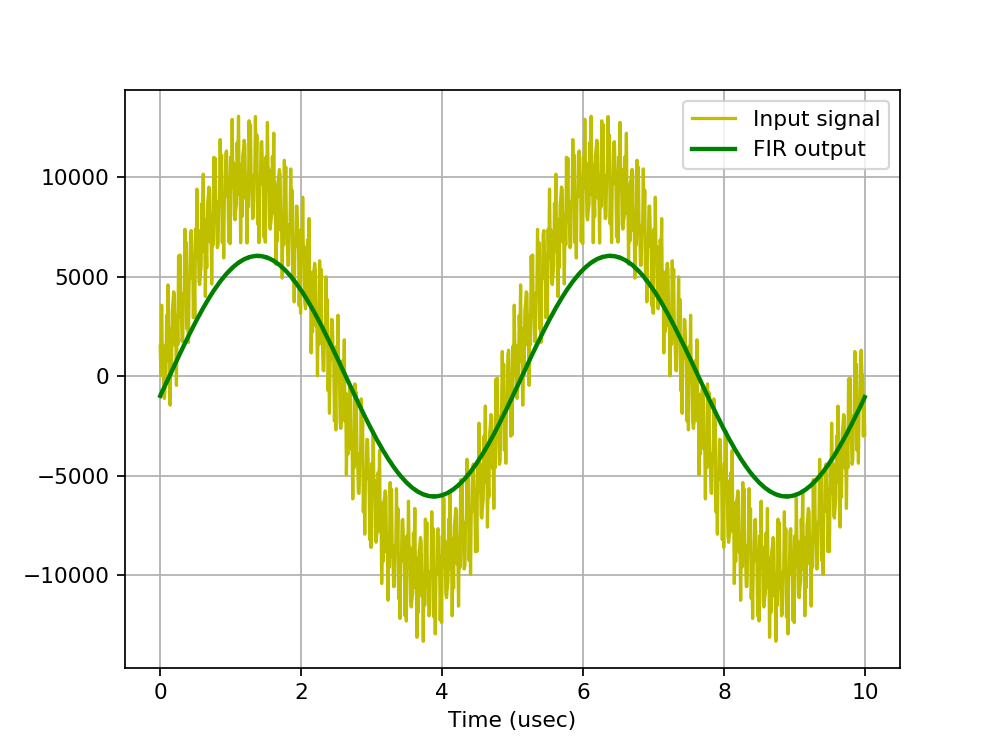

In [8]:
from pynq import Xlnk
import numpy as np

# Allocate buffers for the input and output signals
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(n,), dtype=np.int32)
out_buffer = xlnk.cma_array(shape=(n,), dtype=np.int32)

# Copy the samples to the in_buffer
np.copyto(in_buffer, samples)

# Trigger the DMA transfer and wait for the result
import time
start_time = time.time()
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time-start_time
print('Hardware FIR execution time: ',hw_exec_time)
print('Hardware acceleration factor: ',sw_exec_time / hw_exec_time)

# Plot to the notebook
plot_to_notebook(t, samples, 1000, out_signal=out_buffer)

# Free the buffers
in_buffer.close()
out_buffer.close()

### Driver for FIR accelerator
To hide the details of the DMA from the programmer, and make the accelerator easier to use, we create a driver for it. Below is the driver that will be associated with the `filter` hierarchy that we created in Vivado, consisting of the FIR IP and the DMA.

In [ ]:
from pynq import DefaultHierarchy

class FirDriver(DefaultHierarchy):
    def __init__(self, description):
        super().__init__(description=description)
    
    def fir_filter(self, data):
        with xlnk.cma_array(shape=(len(data),), dtype=np.int32) as in_buffer,\
             xlnk.cma_array(shape=(len(data),), dtype=np.int32) as out_buffer:
            np.copyto(in_buffer,data)
            self.fir_dma.sendchannel.transfer(in_buffer)
            self.fir_dma.recvchannel.transfer(out_buffer)
            self.fir_dma.sendchannel.wait()
            self.fir_dma.recvchannel.wait()
        return result
    
    @staticmethod
    def checkhierarchy(description):
        if 'fir' in description['ip'] \
            and 'fir_dma' in description['ip']:
                return True
        return False


from pynq import Overlay
import pynq.lib.dma
overlay = Overlay('fir_accel.bit')

We need to reload the overlay in order for the driver to be atached to the accelerator.

In [14]:
from pynq import Overlay
import pynq.lib.dma

overlay = Overlay('fir_accel.bit')

# Run the hardware FIR and measure the runtime
start_time = time.time()
result = overlay.filter.fir_filter(samples)
stop_time = time.time()
print('Hardware FIR execution time (with driver): ', stop_time-start_time)

# Plot to the notebook
plot_to_notebook(t, samples, 1000, out_signal=out_buffer)


AttributeError: Could not find IP or hierarchy fir_filter in overlay